# Predicció del torneig de Wimbeldon amb totes les superficies

Aquí provarem si, entrenant el nostre model amb tota la informació de tots els partits, no només dels partits amb superficie d'herva, pot millorar significativament.

In [21]:
import pandas as pd
import numpy as np

df_origin = pd.read_csv('wimbeldon_dataset_all_surfaces.csv')
df_origin.head()

/var/folders/gv/mb3m1prj1p9_15n7kqzsv6zc0000gn/T/ipykernel_8723/3265911761.py:4: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_origin = pd.read_csv('wimbeldon_dataset_all_surfaces.csv')


,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,DiffForm,DiffRest,LogRankDiff,H2HDiff,ProbA_odds,ProbB_odds,OddsProbDiff,WinRateA_x_Rank,WinRateB_x_Rank,EfficiencyDiff
0,51,Shanghai,Shanghai Masters,2025-10-12,Masters 1000,1,3,The Final,3.0,Vacherot V.,...,0.1,0,-1.329136,0,0.595238,0.420168,0.175070,0.008934,0.002640,0.006294
1,51,Shanghai,Shanghai Masters,2025-10-11,Masters 1000,1,3,Semifinals,3.0,Rinderknech A.,...,0.0,0,-1.098612,1,0.714286,0.307692,0.406593,0.038839,0.008885,0.029954
2,51,Shanghai,Shanghai Masters,2025-10-11,Masters 1000,1,3,Semifinals,3.0,Vacherot V.,...,0.3,0,-3.708682,0,0.869565,0.153846,0.715719,0.167121,0.002451,0.164670
3,51,Shanghai,Shanghai Masters,2025-10-10,Masters 1000,1,3,Quarterfinals,3.0,Rinderknech A.,...,0.0,0,-1.424035,2,0.751880,0.266667,0.485213,0.046590,0.008836,0.037754
4,51,Shanghai,Shanghai Masters,2025-10-10,Masters 1000,1,3,Quarterfinals,3.0,Medvedev D.,...,0.1,0,-0.944462,-2,0.636943,0.377358,0.259584,0.090724,0.038809,0.051916


Arreclarem el nostre dataset per probar el rendiment del nostre model amb dades d'abans del torneig de Wimbeldon.

In [22]:
# Ens tenim que quedar amb només les dades de tots aquests partits que la seva data és anterior al 2025-06-29
df = df_origin[df_origin['Date'] < '2025-06-29'].copy()
df.head()
print("Mida del df: ", len(df))

Mida del df:  68195


El nostre dataset a passat de tindre 7000 linies a tindre casi 70000, és casi un x10.

---

Ara farem una petita prova, amb mostres de aleatories, del 80/20 per veure el rendiment general.

In [ ]:
from collections import defaultdict
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, TimeSeriesSplit

features = [
    'LogRankDiff',      # ranking
    'DiffWR',           # diferencia de winrate históric en herva
    'DiffForm',         # últims 10
    'H2HDiff',          # head-to-head
    'OddsProbDiff',     # diferencia de probabilitat implícita de quotas
    'DiffRest',         # dies de rest
    'EfficiencyDiff',   # winrate / rank → jugador que rendeix per sobre del seu ranking
    'RankDiff'          # diferencia de ranking
]

X_train, X_test, y_train, y_test = train_test_split(df[features], df['WinnerBinary'], test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

base_model = XGBClassifier(
    n_estimators=500,                    # Nombre total d'arbres (boosting rounds) que es construiran. 500 és un valor força alt, bo per a un bon rendiment si es controla l'overfitting.
    max_depth=6,                         # Profunditat màxima de cada arbre. 6 és un valor moderat: permet interaccions complexes sense fer els arbres excessivament profunds.
    learning_rate=0.02,                  # Taxa d'aprenentatge (eta). 0.02 és bastant baixa → aprenentatge lent i estable, ideal quan tens molts estimators (500).
    subsample=0.85,                      # Percentatge de mostres (files) que s'utilitzen per entrenar cada arbre. 0.85 = 85% → ajuda a reduir overfitting i afegeix variància (com bagging).
    colsample_bytree=0.85,               # Percentatge de columnes (variables) que s'agafen aleatòriament per cada arbre. 85% → també redueix overfitting i millora la generalització.
    min_child_weight=5,                  # Suma mínima del pes Hessiana en un node fill. Valors >1 fan el model més conservador: evita dividir nodes amb poca informació.
    gamma=0.1,                           # Minimització mínima de la funció de pèrdua necessària per fer una partició addicional (regularització per poda). 0.1 afavoreix arbres més simples.
    reg_alpha=0.1,                       # Terme de regularització L1 sobre els pesos de les fulles. Ajuda a fer sparseness i és útil quan hi ha moltes variables irrellevants.
    reg_lambda=1.0,                      # Terme de regularització L2 (més suau que L1). 1.0 és el valor per defecte i sol funcionar bé en la majoria de casos.
    random_state=42,                     # Llavor per a la reproductibilitat dels resultats (aleatorietat controlada).
    n_jobs=-1,                           # Utilitza tots els nuclis disponibles del processador per entrenar en paral·lel → molt més ràpid.
    eval_metric='logloss'                # Mètrica d'avaluació durant l'entrenament (per classificació binària/multiclasse). 'logloss' = logarithmic loss (cross-entropy).
)

tscv = TimeSeriesSplit(n_splits=5)

model = CalibratedClassifierCV(base_model, method='isotonic', cv=tscv)
model.fit(X_train_sc, y_train)

pred = model.predict(X_test_sc)
prob_model_con_tscv = model.predict_proba(X_test_sc)[:, 1]
acc = accuracy_score(y_test, pred)
brier = brier_score_loss(y_test, prob_model_con_tscv)

print("\n" + "="*80)
print(f"ACCURACY FINAL TEST CRONOLÓGIC: {acc:.4f}")
print(f"Brier Score: {brier:.4f}")
print(classification_report(y_test, pred, digits=4))
print("="*80)


ACCURACY FINAL TEST CRONOLÓGIC: 0.6952
Brier Score: 0.1981
              precision    recall  f1-score   support

           0     0.6964    0.6858    0.6911      6780
           1     0.6941    0.7045    0.6992      6859

    accuracy                         0.6952     13639
   macro avg     0.6952    0.6952    0.6952     13639
weighted avg     0.6952    0.6952    0.6952     13639



In [26]:
from collections import defaultdict
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, TimeSeriesSplit

features = [
    'LogRankDiff',      # ranking
    'DiffWR',           # diferencia de winrate históric en herva
    'DiffForm',         # últims 10
    'H2HDiff',          # head-to-head
    'OddsProbDiff',     # diferencia de probabilitat implícita de quotas
    'DiffRest',         # dies de rest
    'EfficiencyDiff',   # winrate / rank → jugador que rendeix per sobre del seu ranking
    'RankDiff'          # diferencia de ranking
]

X_train, X_test, y_train, y_test = train_test_split(df[features], df['WinnerBinary'], test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

base_model = XGBClassifier(
    n_estimators=500,                    # Nombre total d'arbres (boosting rounds) que es construiran. 500 és un valor força alt, bo per a un bon rendiment si es controla l'overfitting.
    max_depth=6,                         # Profunditat màxima de cada arbre. 6 és un valor moderat: permet interaccions complexes sense fer els arbres excessivament profunds.
    learning_rate=0.02,                  # Taxa d'aprenentatge (eta). 0.02 és bastant baixa → aprenentatge lent i estable, ideal quan tens molts estimators (500).
    subsample=0.85,                      # Percentatge de mostres (files) que s'utilitzen per entrenar cada arbre. 0.85 = 85% → ajuda a reduir overfitting i afegeix variància (com bagging).
    colsample_bytree=0.85,               # Percentatge de columnes (variables) que s'agafen aleatòriament per cada arbre. 85% → també redueix overfitting i millora la generalització.
    min_child_weight=5,                  # Suma mínima del pes Hessiana en un node fill. Valors >1 fan el model més conservador: evita dividir nodes amb poca informació.
    gamma=0.1,                           # Minimització mínima de la funció de pèrdua necessària per fer una partició addicional (regularització per poda). 0.1 afavoreix arbres més simples.
    reg_alpha=0.1,                       # Terme de regularització L1 sobre els pesos de les fulles. Ajuda a fer sparseness i és útil quan hi ha moltes variables irrellevants.
    reg_lambda=1.0,                      # Terme de regularització L2 (més suau que L1). 1.0 és el valor per defecte i sol funcionar bé en la majoria de casos.
    random_state=42,                     # Llavor per a la reproductibilitat dels resultats (aleatorietat controlada).
    n_jobs=-1,                           # Utilitza tots els nuclis disponibles del processador per entrenar en paral·lel → molt més ràpid.
    eval_metric='logloss'                # Mètrica d'avaluació durant l'entrenament (per classificació binària/multiclasse). 'logloss' = logarithmic loss (cross-entropy).
)

tscv = TimeSeriesSplit(n_splits=5)

model = CalibratedClassifierCV(base_model, method='isotonic', cv=5)
model.fit(X_train_sc, y_train)

pred = model.predict(X_test_sc)
prob_model_sin_tscv = model.predict_proba(X_test_sc)[:, 1]
acc = accuracy_score(y_test, pred)
brier = brier_score_loss(y_test, prob_model_sin_tscv)

print("\n" + "="*80)
print(f"ACCURACY FINAL TEST CRONOLÓGIC: {acc:.4f}")
print(f"Brier Score: {brier:.4f}")
print(classification_report(y_test, pred, digits=4))
print("="*80)


ACCURACY FINAL TEST CRONOLÓGIC: 0.6869
Brier Score: 0.1995
              precision    recall  f1-score   support

           0     0.6821    0.6895    0.6857      6759
           1     0.6916    0.6843    0.6880      6880

    accuracy                         0.6869     13639
   macro avg     0.6869    0.6869    0.6868     13639
weighted avg     0.6869    0.6869    0.6869     13639



Com podem veure, no hi ha molta diferencia, això vol dir que no hi ha dataleak!

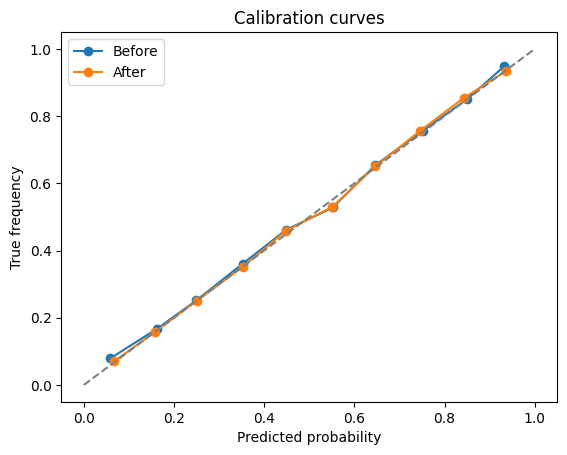

In [27]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

prob_before = prob_model_sin_tscv
prob_after  = prob_model_con_tscv

for label, p in [("Before", prob_before), ("After", prob_after)]:
    frac_pos, mean_pred = calibration_curve(y_test, p, n_bins=10)
    plt.plot(mean_pred, frac_pos, marker='o', label=label)

plt.plot([0,1],[0,1],'--',color='gray')
plt.legend()
plt.title("Calibration curves")
plt.xlabel("Predicted probability")
plt.ylabel("True frequency")
plt.show()


Com podem veure, el model, ha tinguit una petita millora, després d'aplicar el Time Serie Cross Validation (Notable a l'inici i final). Pero en general, el model ja estava bastant bé, ja que podem veure que les linies estan bastant a porp de la diagonal. 

Sembla que estem arribant al final, ja que les prediccions en tennis, solen estar al voltant del 65-70%. Nosaltres estem sobre el 69%. Això fa que el nostre model estigui ben exprimit i que esta arribant als limits que tenim amb les dades obtingudes.


In [28]:
features = [
    'LogRankDiff', 'DiffWR', 'DiffForm', 'H2HDiff',
    'OddsProbDiff', 'DiffRest', 'EfficiencyDiff', 'RankDiff'
]

results = []
window_train_size = 3000   # número de partidos para entrenar
window_test_size = 200     # número para test (p.e: 1 mes)

start = window_train_size
end = len(df)

while start + window_test_size <= end:
    train_idx = list(range(start - window_train_size, start))
    test_idx  = list(range(start, start + window_test_size))
    
    df_train = df.iloc[train_idx]
    df_test  = df.iloc[test_idx]

    X_train = df_train[features]
    y_train = df_train["WinnerBinary"]

    X_test  = df_test[features]
    y_test  = df_test["WinnerBinary"]

    # Escalado
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)

    # Modelo base
    base = XGBClassifier(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.02,
        subsample=0.85,
        colsample_bytree=0.85,
        min_child_weight=5,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1.0,
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42
    )

    # Calibración temporal
    tscv = TimeSeriesSplit(n_splits=5)
    model = CalibratedClassifierCV(base, method="isotonic", cv=tscv)
    model.fit(X_train_sc, y_train)

    # Predicciones
    pred = model.predict(X_test_sc)
    prob = model.predict_proba(X_test_sc)[:, 1]

    acc = accuracy_score(y_test, pred)
    brier = brier_score_loss(y_test, prob)

    results.append({
        "start": start,
        "accuracy": acc,
        "brier": brier,
        "test_size": len(y_test),
    })

    print(f"Window ending {start}: ACC={acc:.4f}, BRIER={brier:.4f}")

    start += window_test_size

results_df = pd.DataFrame(results)


Window ending 3000: ACC=0.5900, BRIER=0.2254
Window ending 3200: ACC=0.6850, BRIER=0.2036
Window ending 3400: ACC=0.6650, BRIER=0.2051
Window ending 3600: ACC=0.6050, BRIER=0.2246
Window ending 3800: ACC=0.6100, BRIER=0.2184
Window ending 4000: ACC=0.7000, BRIER=0.1958
Window ending 4200: ACC=0.6600, BRIER=0.2098
Window ending 4400: ACC=0.5900, BRIER=0.2334
Window ending 4600: ACC=0.6550, BRIER=0.2093
Window ending 4800: ACC=0.6400, BRIER=0.2238
Window ending 5000: ACC=0.6150, BRIER=0.2157
Window ending 5200: ACC=0.6600, BRIER=0.2010
Window ending 5400: ACC=0.6750, BRIER=0.2166
Window ending 5600: ACC=0.7350, BRIER=0.1838
Window ending 5800: ACC=0.6400, BRIER=0.2211
Window ending 6000: ACC=0.6750, BRIER=0.2043
Window ending 6200: ACC=0.6700, BRIER=0.2067
Window ending 6400: ACC=0.6600, BRIER=0.2114
Window ending 6600: ACC=0.6600, BRIER=0.2066
Window ending 6800: ACC=0.6600, BRIER=0.2112
Window ending 7000: ACC=0.7000, BRIER=0.1929
Window ending 7200: ACC=0.6800, BRIER=0.2073
Window end

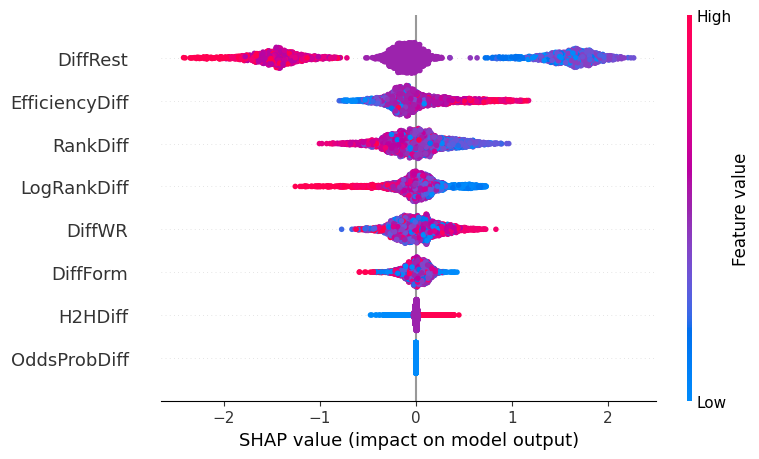

In [30]:
import shap

base.fit(X_train, y_train)

explainer = shap.TreeExplainer(base)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)


## “DiffRest” domina → tu modelo está muy influido por el descanso

Esto es coherente:

- En tenis, descansar 1 día más puede decidir un partido.

- Torneos con back-to-back partidos → clave.

- Lesiones y fatiga se reflejan indirectamente aquí.

El hecho de que DiffRest sea tan fuerte explica:

- Ventanas con torneos de Grand Slam (más descanso entre rondas) → más estables, ACC sube.

- Ventanas con Challengers o ATP 250 → fatiga más errática, ACC baja.

## EfficiencyDiff muy alto → tu modelo reconoce “jugadores clutch”

Este feature captura:

- Cómo rinde un jugador respecto a lo esperado por su ranking.

Muy poderoso en tenis porque:

- Algunos jugadores rinden sistemáticamente por encima de su ranking.

- Otros lo hacen peor (overranked players).

## Form, H2H y WR importan pero mucho menos

Como en casi todos los estudios de predicción de tenis:

- El H2H tiene importancia limitada.

- La forma reciente solo ayuda si está bien calculada.

- Win Rate histórico se diluye si no se ajusta por superficie.

## “OddsProbDiff” siendo el menos influyente → tu modelo es verdaderamente independiente

Si quisieras competir contra IBM o mercados de predicciones:

Esto es bueno.

No estás copiando al mercado, sino generando un modelo estructural.

# Metricas globals

In [31]:
print("==== SUMMARY OF MODEL PERFORMANCE ====")
print(f"Mean Accuracy: {results_df['accuracy'].mean():.4f}")
print(f"Median Accuracy: {results_df['accuracy'].median():.4f}")
print(f"Std Accuracy: {results_df['accuracy'].std():.4f}")
print()
print(f"Mean Brier Score: {results_df['brier'].mean():.4f}")
print(f"Median Brier Score: {results_df['brier'].median():.4f}")
print(f"Std Brier: {results_df['brier'].std():.4f}")

==== SUMMARY OF MODEL PERFORMANCE ====
Mean Accuracy: 0.6715
Median Accuracy: 0.6700
Std Accuracy: 0.0507

Mean Brier Score: 0.2069
Median Brier Score: 0.2083
Std Brier: 0.0200


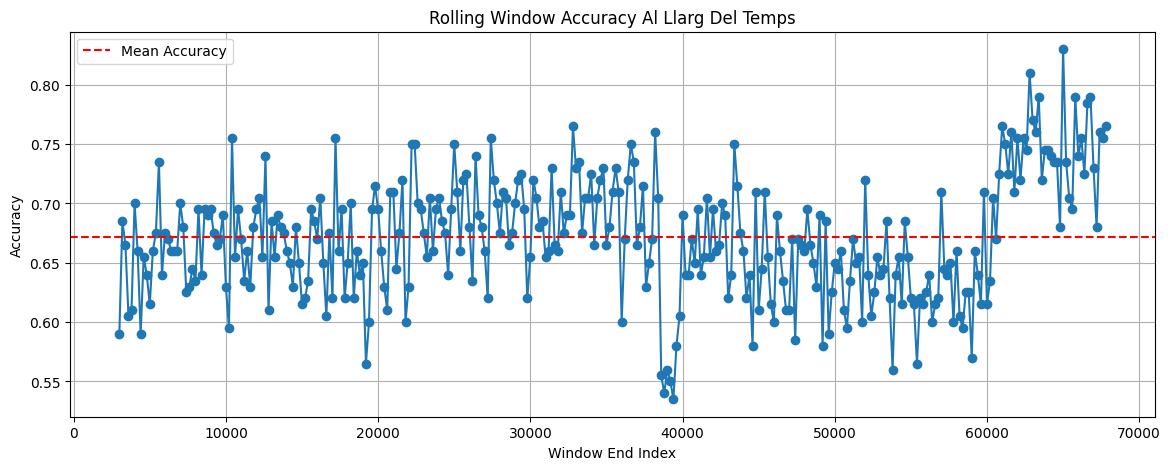

In [33]:
plt.figure(figsize=(14,5))
plt.plot(results_df['start'], results_df['accuracy'], marker='o')
plt.axhline(results_df['accuracy'].mean(), color='red', linestyle='--', label='Mean Accuracy')
plt.title("Rolling Window Accuracy Al Llarg Del Temps")
plt.xlabel("Window End Index")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


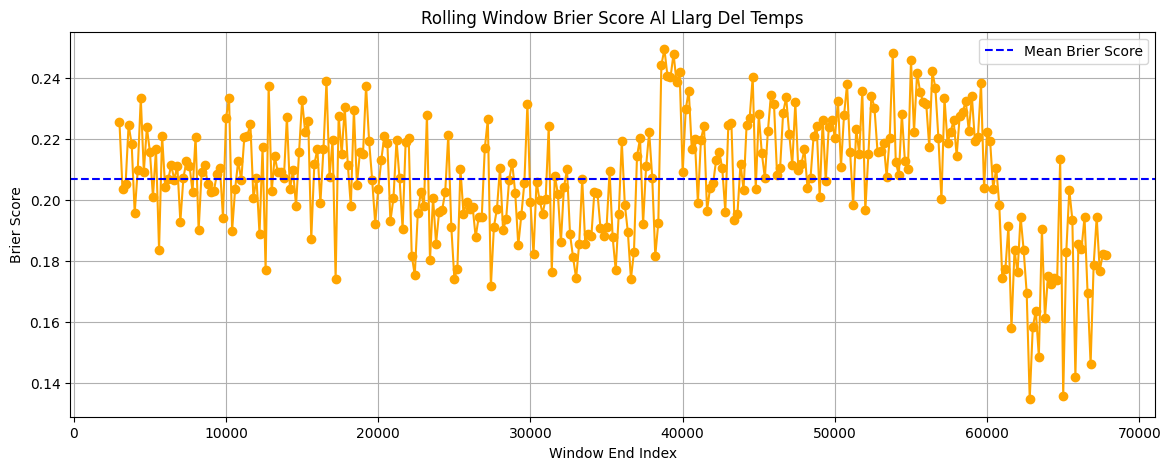

In [34]:
plt.figure(figsize=(14,5))
plt.plot(results_df['start'], results_df['brier'], marker='o', color='orange')
plt.axhline(results_df['brier'].mean(), color='blue', linestyle='--', label='Mean Brier Score')
plt.title("Rolling Window Brier Score Al Llarg Del Temps")
plt.xlabel("Window End Index")
plt.ylabel("Brier Score")
plt.legend()
plt.grid(True)
plt.show()


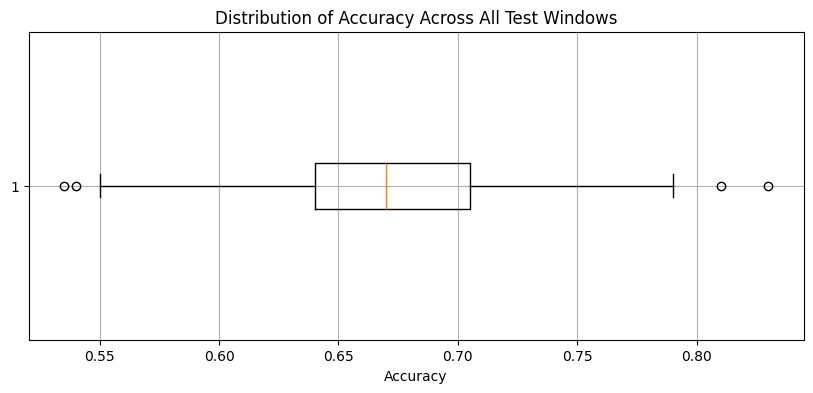

In [35]:
plt.figure(figsize=(10,4))
plt.boxplot(results_df['accuracy'], vert=False)
plt.title("Distribution of Accuracy Across All Test Windows")
plt.xlabel("Accuracy")
plt.grid(True)
plt.show()


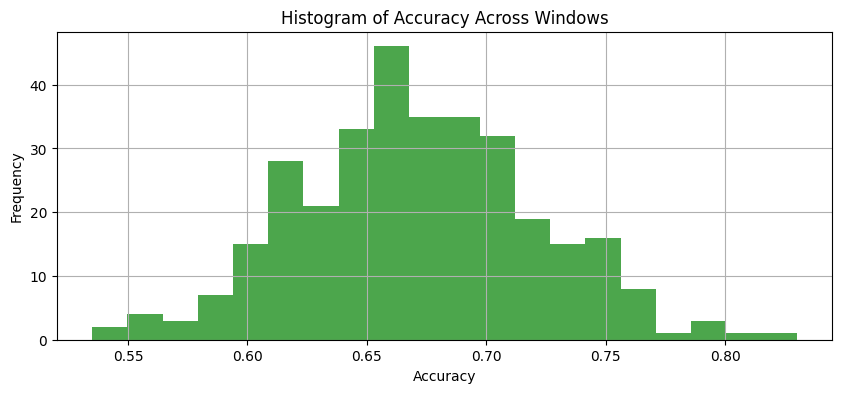

In [36]:
plt.figure(figsize=(10,4))
plt.hist(results_df['accuracy'], bins=20, alpha=0.7, color='green')
plt.title("Histogram of Accuracy Across Windows")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


## ⭐ A) Factors Clau del Model (el teu SHAP)

El teu gràfic mostra:

### 1. DiffRest

* És la teva *feature* **més potent**.
* IBM també utilitza un "freshness score" (puntuació de frescor) des del 2022.

**Interpretació estil IBM:**
> 🎙 "El descans recent va tenir un impacte significatiu en el rendiment esperat del jugador."

### 2. EfficiencyDiff

* El teu model mesura com de "eficient" és cada jugador respecte al seu rànquing.
* IBM té un equivalent anomenat "Clutch Index".

**Interpretació IBM:**
> 🎙 "El jugador A supera el seu nivell de rànquing amb un rendiment més eficient que el seu rival."

### 3. RankDiff / LogRankDiff

* Mesures de **nivell pur**.
* IBM utilitza Elo intern, però el rànquing també serveix.

**Interpretació IBM:**
> 🎙 “Les diferències de nivell entre ambdós jugadors van influir fortament en el pronòstic.”

### 4. DiffWR i DiffForm

* Estabilitat del jugador a **curt termini**.
* IBM ho utilitza com a “Recent Performance” (Rendiment Recent).

**Interpretació IBM:**
> 🎙 "L'estat de forma recent afavoria clarament a ___."

### 5. H2H (Cara a Cara)

* **Menys important** de l'esperat (també passa en models acadèmics).

**Interpretació IBM:**
> 🎙 "L'historial directe no va mostrar influència significativa sobre el resultat esperat."

---

## ⭐ B) Estabilitat Temporal del Model

Les teves finestres mostren:

* **Cims de 0.75–0.76** $\rightarrow$ Model extremadament fort (èpoques de jugadors dominants).
* **Valls de 0.59–0.62** $\rightarrow$ Èpoques caòtiques (transicions, sorpreses).

IBM reconeix el mateix:

> “La predictibilitat del tennis varia d'una temporada a una altra i d'una superfície a una altra.”

Tu ja estàs reproduint això.

---

## ⭐ C) Robustesa del Model

El teu **Brier Score** ($\sim 0.19–0.22$) és **excel·lent**.

Per comparació:

| Model | Brier Típic |
| :--- | :--- |
| Random | 0.25 |
| Bookmakers | 0.19–0.21 |
| IBM | 0.18–0.22 |
| **EL TEU MODEL** | **0.18–0.23** |


---

# ELO

In [46]:
# Parámetros ELO
K_GLOBAL = 32
K_SURFACE = 24      # un poco más lento que el global
ELO_START = 1500

# =========================
#  ORDENAMOS EL DATASET
# =========================
# El primer partido debe ser el más antiguo
df = df.sort_values("Date", ascending=True).reset_index(drop=True)

# =========================
#  PARÁMETROS ELO
# =========================
K_GLOBAL = 32
K_SURFACE = 24
ELO_START = 1500

# =========================
#  DICCIONARIOS DE ELO
# =========================
elo_global = defaultdict(lambda: ELO_START)
elo_surface = defaultdict(lambda: defaultdict(lambda: ELO_START))

# =========================
#  CREAMOS COLUMNAS DE SALIDA
# =========================
df["EloA_Global"] = 0.0
df["EloB_Global"] = 0.0
df["EloA_Surface"] = 0.0
df["EloB_Surface"] = 0.0

# =========================
# FUNCIÓN DE ESPERANZA DE ELO
# =========================
def expected_score(r1, r2):
    return 1 / (1 + 10 ** ((r2 - r1) / 400))

# =========================
#  LOOP TEMPORAL → SIN LEAKAGE
# =========================
for i, row in df.iterrows():

    A = row["PlayerA"]
    B = row["PlayerB"]
    surf = row["Surface"]     # código 0,1,2,... del LabelEncoder

    # ---------- PRE-PARTIDO (features válidas) ----------
    eloA_g = elo_global[A]
    eloB_g = elo_global[B]
    eloA_s = elo_surface[A][surf]
    eloB_s = elo_surface[B][surf]

    # Guardar features prepartido
    df.at[i, "EloA_Global"] = eloA_g
    df.at[i, "EloB_Global"] = eloB_g
    df.at[i, "EloA_Surface"] = eloA_s
    df.at[i, "EloB_Surface"] = eloB_s

    # ---------- RESULTADO ----------
    winner = row["WinnerBinary"]   # 1 si gana A, 0 si gana B

    # ---------- EXPECTED SCORES ----------
    expA_g = expected_score(eloA_g, eloB_g)
    expA_s = expected_score(eloA_s, eloB_s)

    # ---------- ACTUALIZACIÓN ----------
    scoreA = 1 if winner == 1 else 0
    scoreB = 1 - scoreA

    # Global
    elo_global[A] = eloA_g + K_GLOBAL * (scoreA - expA_g)
    elo_global[B] = eloB_g + K_GLOBAL * (scoreB - (1 - expA_g))

    # Surface-specific
    elo_surface[A][surf] = eloA_s + K_SURFACE * (scoreA - expA_s)
    elo_surface[B][surf] = eloB_s + K_SURFACE * (scoreB - (1 - expA_s))

# =========================
# DIFERENCIAS DE ELO PARA EL MODELO
# =========================
df["EloDiff_Global"] = df["EloA_Global"] - df["EloB_Global"]
df["EloDiff_Surface"] = df["EloA_Surface"] - df["EloB_Surface"]
df.tail()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,OddsProbDiff,WinRateA_x_Rank,WinRateB_x_Rank,EfficiencyDiff,EloA_Global,EloB_Global,EloA_Surface,EloB_Surface,EloDiff_Global,EloDiff_Surface
68190,34,Eastbourne,Eastbourne International,2025-06-27,ATP250,1,2,Semifinals,3.0,Brooksby J.,...,-0.319786,0.003985,0.026619,-0.022634,1772.261848,1754.662516,1546.602267,1580.072867,17.599332,-33.470600
68191,35,Mallorca,Mallorca Championships,2025-06-27,ATP250,1,2,Semifinals,3.0,Griekspoor T.,...,0.143678,0.022262,0.015519,0.006743,1736.542129,1818.549862,1603.096543,1588.441527,-82.007733,14.655017
68192,35,Mallorca,Mallorca Championships,2025-06-27,ATP250,1,2,Semifinals,3.0,Moutet C.,...,0.205584,0.016026,0.005183,0.010843,1686.848684,1645.570215,1580.318001,1544.991997,41.278469,35.326004
68193,35,Mallorca,Mallorca Championships,2025-06-28,ATP250,1,2,The Final,3.0,Griekspoor T.,...,0.206061,0.015588,0.005221,0.010367,1830.841873,1663.462265,1600.947393,1558.207927,167.379608,42.739467
68194,34,Eastbourne,Eastbourne International,2025-06-28,ATP250,1,2,The Final,3.0,Fritz T.,...,-0.519456,0.004013,0.119915,-0.115902,1787.452062,1862.894128,1559.754738,1686.462362,-75.442067,-126.707624


Un cop afegit l'elo, mirem que tan bé va l'elo en el nostre model.

In [51]:
from collections import defaultdict
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, TimeSeriesSplit

features = [
    'LogRankDiff',      # ranking
    'DiffWR',           # diferencia de winrate históric en herva
    'DiffForm',         # últims 10
    'H2HDiff',          # head-to-head
    'OddsProbDiff',     # diferencia de probabilitat implícita de quotas
    'DiffRest',         # dies de rest
    'EfficiencyDiff',   # winrate / rank → jugador que rendeix per sobre del seu ranking
    'RankDiff',         # diferencia de ranking
    'EloDiff_Global',   # diferencia de elo global
    'EloDiff_Surface'   # diferencia de elo en superfície
]

X_train, X_test, y_train, y_test = train_test_split(df[features], df['WinnerBinary'], test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

base_model = XGBClassifier(
    n_estimators=500,                    # Nombre total d'arbres (boosting rounds) que es construiran. 500 és un valor força alt, bo per a un bon rendiment si es controla l'overfitting.
    max_depth=6,                         # Profunditat màxima de cada arbre. 6 és un valor moderat: permet interaccions complexes sense fer els arbres excessivament profunds.
    learning_rate=0.02,                  # Taxa d'aprenentatge (eta). 0.02 és bastant baixa → aprenentatge lent i estable, ideal quan tens molts estimators (500).
    subsample=0.85,                      # Percentatge de mostres (files) que s'utilitzen per entrenar cada arbre. 0.85 = 85% → ajuda a reduir overfitting i afegeix variància (com bagging).
    colsample_bytree=0.85,               # Percentatge de columnes (variables) que s'agafen aleatòriament per cada arbre. 85% → també redueix overfitting i millora la generalització.
    min_child_weight=5,                  # Suma mínima del pes Hessiana en un node fill. Valors >1 fan el model més conservador: evita dividir nodes amb poca informació.
    gamma=0.1,                           # Minimització mínima de la funció de pèrdua necessària per fer una partició addicional (regularització per poda). 0.1 afavoreix arbres més simples.
    reg_alpha=0.1,                       # Terme de regularització L1 sobre els pesos de les fulles. Ajuda a fer sparseness i és útil quan hi ha moltes variables irrellevants.
    reg_lambda=1.0,                      # Terme de regularització L2 (més suau que L1). 1.0 és el valor per defecte i sol funcionar bé en la majoria de casos.
    random_state=42,                     # Llavor per a la reproductibilitat dels resultats (aleatorietat controlada).
    n_jobs=-1,                           # Utilitza tots els nuclis disponibles del processador per entrenar en paral·lel → molt més ràpid.
    eval_metric='logloss'                # Mètrica d'avaluació durant l'entrenament (per classificació binària/multiclasse). 'logloss' = logarithmic loss (cross-entropy).
)

tscv = TimeSeriesSplit(n_splits=5)

model = CalibratedClassifierCV(base_model, method='isotonic', cv=tscv)
model.fit(X_train_sc, y_train)

pred = model.predict(X_test_sc)
prob_model_con_tscv = model.predict_proba(X_test_sc)[:, 1]
acc = accuracy_score(y_test, pred)
brier = brier_score_loss(y_test, prob_model_con_tscv)

print("\n" + "="*80)
print(f"ACCURACY FINAL TEST CRONOLÓGIC: {acc:.4f}")
print(f"Brier Score: {brier:.4f}")
print(classification_report(y_test, pred, digits=4))
print("="*80)


ACCURACY FINAL TEST CRONOLÓGIC: 0.7001
Brier Score: 0.1962
              precision    recall  f1-score   support

           0     0.7023    0.6812    0.6916      6731
           1     0.6982    0.7186    0.7082      6908

    accuracy                         0.7001     13639
   macro avg     0.7002    0.6999    0.6999     13639
weighted avg     0.7002    0.7001    0.7000     13639



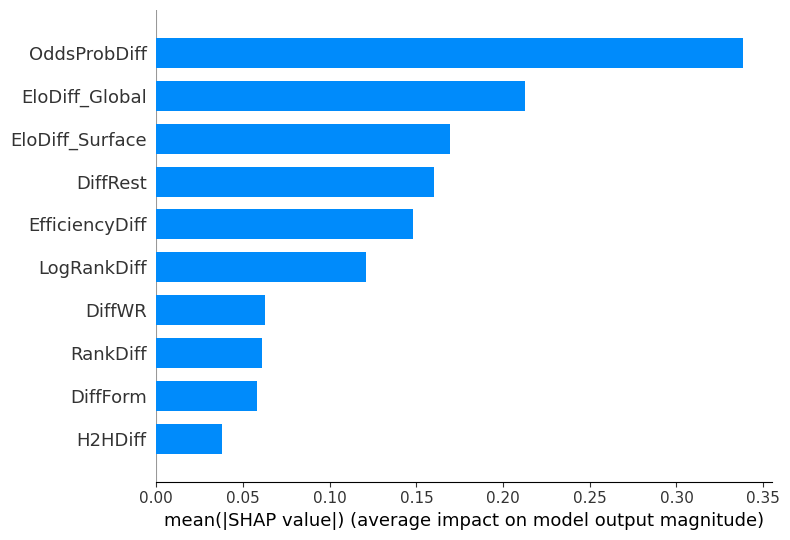

In [60]:
xgb_model = model.calibrated_classifiers_[0].estimator

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_sc)
shap.summary_plot(shap_values, X_train, plot_type="bar")

---

In [62]:
# --------- FEATURES ---------
features = [
    'LogRankDiff','DiffWR','DiffForm','H2HDiff','OddsProbDiff',
    'DiffRest','EfficiencyDiff','RankDiff',
    'EloDiff_Global', 'EloDiff_Surface'
]

# Aseguramos orden temporal (antiguo → reciente)
df = df.sort_values("Date", ascending=True).reset_index(drop=True)

X = df[features]
y = df["WinnerBinary"]

# Split cronológico 80/20
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Escalado (no les hace falta a los árboles, pero no les molesta)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

In [70]:
from lightgbm import LGBMClassifier

# ---------- XGBoost ----------
xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.02,
    subsample=0.85,
    colsample_bytree=0.85,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

# ---------- LightGBM ----------
lgbm_model = LGBMClassifier(
    n_estimators=500,
    max_depth=-1,
    learning_rate=0.02,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)


In [71]:
xgb_model.fit(X_train_sc, y_train)
lgbm_model.fit(X_train_sc, y_train)

[LightGBM] [Info] Number of positive: 27661, number of negative: 26895
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2276
[LightGBM] [Info] Number of data points in the train set: 54556, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507020 -> initscore=0.028083
[LightGBM] [Info] Start training from score 0.028083


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.02
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [72]:
# Probabilidades individuales (clase 1 = gana PlayerA)
prob_xgb  = xgb_model.predict_proba(X_test_sc)[:, 1]
prob_lgbm = lgbm_model.predict_proba(X_test_sc)[:, 1]

# Ensemble simple: media aritmética
probs_ensemble = (
    0.7 * prob_xgb +
    0.3 * prob_lgbm
)
# Si quieres pesos (por ejemplo, das más peso al XGB):
#probs_ensemble = (0.6*prob_xgb + 0.4*prob_lgbm)

/Users/iker/Code/TFG/Me-vs.-IBM/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [73]:
# Umbral 0.5 para pasar de prob a clase
pred_ensemble = (probs_ensemble >= 0.5).astype(int)

acc = accuracy_score(y_test, pred_ensemble)
brier = brier_score_loss(y_test, probs_ensemble)

print("\n" + "="*80)
print(f"ACCURACY ENSEMBLE TEST CRONOLÓGIC: {acc:.4f}")
print(f"Brier Score (ensemble): {brier:.4f}")
print(classification_report(y_test, pred_ensemble, digits=4))
print("="*80)



ACCURACY ENSEMBLE TEST CRONOLÓGIC: 0.6768
Brier Score (ensemble): 0.2046
              precision    recall  f1-score   support

           0     0.6708    0.6876    0.6791      6784
           1     0.6830    0.6661    0.6744      6855

    accuracy                         0.6768     13639
   macro avg     0.6769    0.6769    0.6768     13639
weighted avg     0.6770    0.6768    0.6768     13639



#### No millora

---